# Practice 13 - Dimensionality Reduction
In this lab we will use Dimensionality Reduction methods for classification. \
Based on Chapter 8 from Aurelien Geron's book, Hands-on Machine Learning with Scikit-Learn Keras & Tensorflow.\
Original code examples from book in github [here](https://github.com/ageron/handson-ml2)

In [54]:
!conda info --envs

# conda environments:
#
base                     /home/dtrad/anaconda3
pycuda                   /home/dtrad/anaconda3/envs/pycuda
pydas                    /home/dtrad/anaconda3/envs/pydas
pydas2                   /home/dtrad/anaconda3/envs/pydas2
pytorchgpu               /home/dtrad/anaconda3/envs/pytorchgpu
tfgpu                 *  /home/dtrad/anaconda3/envs/tfgpu



In [55]:
import sklearn
sklearn.__version__

'1.1.2'

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice13-DimRed.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [56]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
sklearn.set_config(print_changed_only=False)

## Exercise 1: PCA and SVD 
Using the data set in 3 dimensions generated by the code below:\
a) Take its SVD, check you can reconstruct the original data (using np).\
b) Make zero one of the eigenvalues and do the same reconstruction. Plot in 3D \
c) Do a projection onto the principal axes using all dimensions. Use numpy first then sklearn.\
d) Do a projection onto the two principal axes only. Plot in 2D.\
e) Do a reconstruction in 3D from the 2D projection. Plot in 3D.

In [57]:
from mpl_toolkits import mplot3d

The data is generated in a way that only 2 dimensions are independent and the 3rd is just a linear combination of the others plus noise.

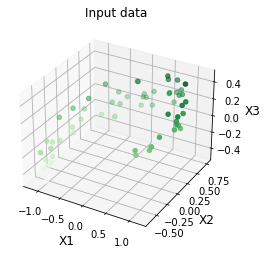

In [58]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0],X[:,1], X[:,2],c=X[:,2], cmap='Greens');
ax.set_xlabel('X1',fontsize='12')
ax.set_ylabel('X2',fontsize='12')
ax.set_zlabel('X3',fontsize='12')
plt.title('Input data');

We can use numpy.linalg.svd:\
${\bf U,S,V}=svd(X)$ implies that $\bf X= U S V^T$\
notice typically svd will give you $\bf V$ (singular vectors along columns), but numpy gives you $\bf V^T$\
$\bf V$ has physical meaning, $\bf V^T$ doesn't.\
We need to center the instances first

In [59]:
XC = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(XC)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]
print("V=",Vt.T)
print("first singular vector is the first column of V -->",c1)

V= [[ 0.93636116 -0.34027485 -0.08626012]
 [ 0.29854881  0.90119108 -0.31420255]
 [ 0.18465208  0.2684542   0.94542898]]
first singular vector is the first column of V --> [0.93636116 0.29854881 0.18465208]


The size for the singular value matrix **s** has to match their inner dimensions to $\bf U$ and $\bf V$ so they can be multiplied.\
The numpy algorithm returns only a vector with the singular values, so to form the matrix $\bf S$ we need to cast it into a matrix with the proper size.


In [60]:
print(U.shape)
print(s.shape)
print(Vt.shape)
print(X.shape)

(60, 60)
(3,)
(3, 3)
(60, 3)


Check that U and V are orthonormal matrices

In [61]:
print(Vt.dot(Vt.T))
UUT=(U.T.dot(U))
udiag=[UUT[i,i] for i in range(60)]
print(min(udiag), max(udiag))

[[ 1.00000000e+00  2.10214619e-16 -1.89701135e-17]
 [ 2.10214619e-16  1.00000000e+00  1.02986929e-16]
 [-1.89701135e-17  1.02986929e-16  1.00000000e+00]]
0.9999999999999996 1.000000000000001


Notice the "@" for matrix multiplication instead of "*". Both forms are equivalent (the @ is only python 3.X)

Now let us reconstruct X by multiplying the SVD components.\
s is a vector, we need a matrix size (60,3). Just for convenience, let us do this with the linalg package.

In [62]:
import scipy.linalg as la
print('data shape',X.shape)
S=la.diagsvd(s,*X.shape)
print('singular value matrix put into a matrix of shape',S.shape)
#now we can multiply the three to recover the data space.
XR=U@S@Vt
print("reconstruction error between %1.1e and %1.1e"%((XR - XC).min(), (XR-XC).max()))

data shape (60, 3)
singular value matrix put into a matrix of shape (60, 3)
reconstruction error between -1.0e-15 and 8.0e-16


Text(0.5, 0.92, 'Reconstructed via $U * S * V^T $')

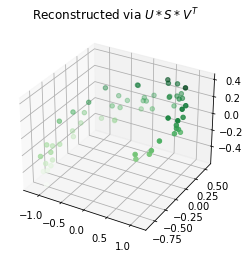

In [63]:
fig= plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(XR[:,0],XR[:,1], XR[:,2],c=XR[:,2], cmap='Greens');
plt.title('Reconstructed via $U * S * V^T $')

Now let us start doing dimensionality reduction by eliminating one of the V columns (basis function for the transformed space).

Original singular value vector [6.77645005 2.82403671 0.78116597]
New singular values [6.77645005 2.82403671 0.        ]
reconstruction error between -1.9e-01 and 1.8e-01


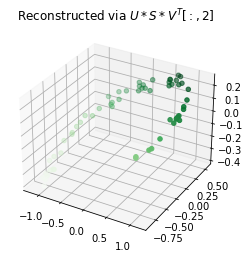

In [64]:
# now let eliminate one of the 3 dimensions by making the smaller singular value equal to 0
print('Original singular value vector',s)
ss=np.copy(s) ## we don't want to change the original array s so we need a deep copy
ss[2]=0;
print('New singular values',ss)
SS=la.diagsvd(ss,*X.shape)
XR2=U@SS@Vt
print("reconstruction error between %1.1e and %1.1e"%((XR2 - XC).min(), (XR2-XC).max()))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(XR2[:,0],XR2[:,1], XR2[:,2],c=XR2[:,2], cmap='Greens');
plt.title('Reconstructed via $U * S * V^T[:,2] $')
plt.show()

We see now the points are scattered along a plane (2D) embeded in 3D.

reconstruction error between -1.9e-01 and 1.8e-01


Text(0.5, 0.92, 'Reconstructed via $U * S * V^T $')

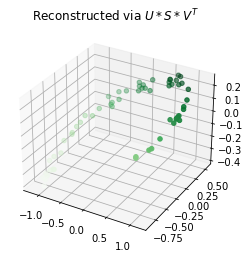

In [65]:
#another way with numpy only (without using scipy)
XC = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(XC)
m, n = X.shape
S = np.zeros(XC.shape)
S[:n, :n] = np.diag(s)
S[2,2]=0 # uncomment to reduce dimension to 2D.
XR = U.dot(S).dot(Vt)
print("reconstruction error between %1.1e and %1.1e"%((XR - XC).min(), (XR-XC).max()))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(XR[:,0],XR[:,1], XR[:,2],c=XR[:,2], cmap='Greens');
plt.title('Reconstructed via $U * S * V^T $')

In the previous cases we reconstructed the data by using their component ${\bf U \times S \times V^T}$.\
We can also think of V as an orthogonal transform. \
Any data multiplied by $\bf V$ gets transformed (similar to a forward Fourier transform), \
A transform multiplied by $\bf V^T$ is reconstructed (similar to an inverse Fourier transform).\
Since $\bf V \times V^T = I$, as long as we use all columns of $\bf V$, nothing is lost. 

In [66]:
## SVD as a transform
XC = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(XC)
XR=XC.dot(Vt.T)  # Forward transform, multiply times V
XRI=XR.dot(Vt)   # Inverse transform, multiply times VT
print("reconstruction error between %1.1e and %1.1e"%((XRI - XC).min(), (XRI-XC).max()))

reconstruction error between -4.4e-16 and 4.4e-16


### SVD as a transform onto data and model basis functions
Since we can map a transformed data back to its original space by multiplying by $\bf V^T$ \
we see the columns of $V$ are the basis functions of the transformed space.\
This is each vector in the data set is projected along the V vectors that form the basis functions of 3D.\
### Remember:
* Each column of U is a basis function of the data space.
* Each column of V is a basis function of the model space.
* Each element of S is the strength of the mapping between data and model.

By eliminating one component of S or one vector of V we are reducing dimensionality.\
(when multiplying $C = A * B^T$ using matrix product, each column of C is the projection (dot product)\
of one column of A with a column of B)

In [67]:
print(Vt.T[:,:3])

[[ 0.93636116 -0.34027485 -0.08626012]
 [ 0.29854881  0.90119108 -0.31420255]
 [ 0.18465208  0.2684542   0.94542898]]


V= [[ 0.93636116 -0.34027485 -0.08626012]
 [ 0.29854881  0.90119108 -0.31420255]
 [ 0.18465208  0.2684542   0.94542898]]
W2 [[ 0.93636116 -0.34027485  0.        ]
 [ 0.29854881  0.90119108  0.        ]
 [ 0.18465208  0.2684542   0.        ]]
(60, 3)


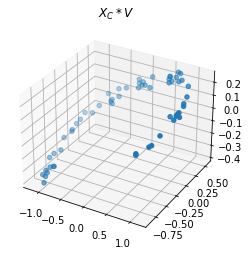

In [68]:
# let us do a projection on 3D
W2 = np.copy(Vt.T[:, :3]) # this is just V
print('V=',Vt.T)
W2[:,2]=0
print('W2',W2)
# any data multiplied by V is transformed (U*s*VT*V=U*s)
XP = XC.dot(W2)
# any transform multiplied by VT (transposed) is inverse transformed (U*s*VT=X)
X3D = XP.dot(W2.T)
print(X3D.shape)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X3D[:,0],X3D[:,1], X3D[:,2], cmap='Greens');
plt.title("$ X_C * V $")
plt.show()

### Using sklearn PCA
Using scikit-learn is of easy since this code is already implemented into the PCA class\
using the familiar interface "fit_transform()" that we normally use and inverse_transform (instead of predict)

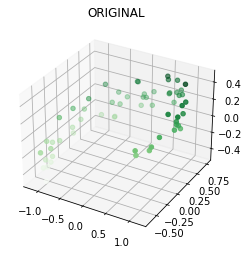

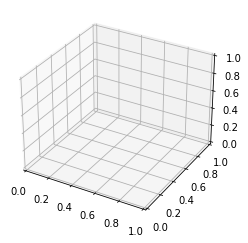

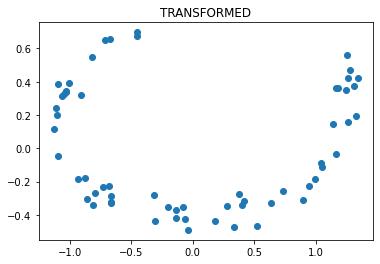

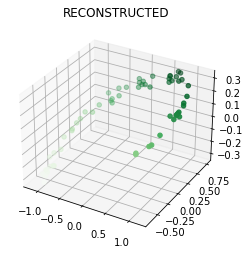

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X3D = pca.fit_transform(X)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0],X[:,1], X[:,2],c=X[:,2], cmap='Greens');plt.title('ORIGINAL')
plt.show()

try:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X3D[:,0],X3D[:,1], X3D[:,2],c=X3D[:,2], cmap='Greens');plt.title('TRANSFORMED')
    plt.show()
except:
    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(X3D[:,0],X3D[:,1], cmap='Greens');plt.title('TRANSFORMED')
    plt.show()

X3DI = pca.inverse_transform(X3D)
ax = plt.axes(projection='3d')
ax.scatter3D(X3DI[:,0],X3DI[:,1], X3DI[:,2],c=X3DI[:,2], cmap='Greens');plt.title('RECONSTRUCTED')
plt.show()


We can see the projection in 2D by projecting the data onto the two main vectors of V (using the dot product, column by column)

## Exercise 2: Manifold Learning
Use the Swiss roll data generated below:\
a) Remove one of the dimensions by squeezing it.\
b) Remove one of the dimensions by using the values as the spatial parameter.\
c) Apply dimensionality reduction to 2 components using PCA\
d) Apply dimensionality reduction to 2 components using linear PCA\
e) Apply dimensionality reduction to 2 components using Kernel PCA


(1000, 3) (1000,)


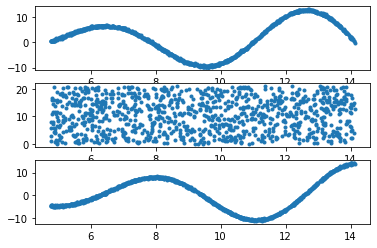

In [70]:
# returns 
# X : array of shape [n_samples, 3], the points.
# t : array of shape [n_samples], the univariate position of the samples along of the main dimension
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
print(X.shape,t.shape)
plt.subplot(311)
plt.plot(t,X[:,0],'.')
plt.subplot(312)
plt.plot(t,X[:,1],'.')
plt.subplot(313)
plt.plot(t,X[:,2],'.')

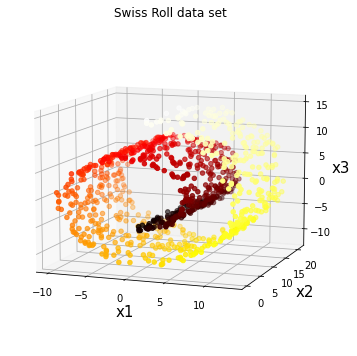

In [71]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0],X[:,1], X[:,2],c=t, cmap=plt.cm.hot);
ax.view_init(10, -70)
ax.set_xlabel('x1',fontsize='15')
ax.set_ylabel('x2',fontsize='15')
ax.set_zlabel('x3',fontsize='15')
plt.title('Swiss Roll data set')
plt.show()

Squeezing one dimension is easy (similar to stacking seismic data). We just plot 3D data in 2D.\
Spreading along a parameter is also easy if we have the parameter. \
Notice that is only good along the main dimension for which t is designed for.



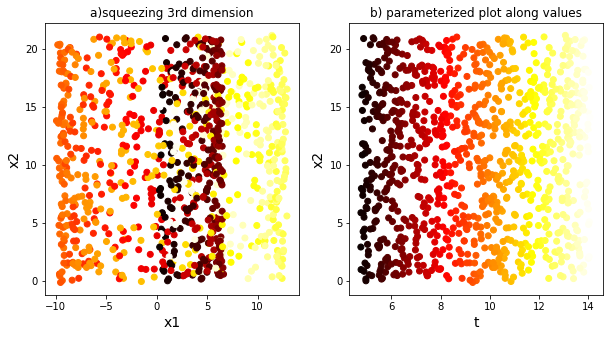

In [72]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X[:,0],X[:,1],c=t, cmap=plt.cm.hot);
plt.title("a)squeezing 3rd dimension")
plt.xlabel('x1',fontsize='14')
plt.ylabel('x2',fontsize='14')
plt.subplot(122)
plt.scatter(t,X[:,1],c=t, cmap=plt.cm.hot);
plt.title("b) parameterized plot along values")
plt.xlabel('t',fontsize='14')
plt.ylabel('x2',fontsize='14')
plt.show()

Now, we will use PCA. We calculate $\bf V$ (fit) and project (transform) in one step with fit_transform.

(1000, 2)


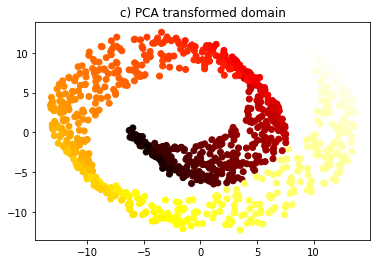

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
print(X2D.shape)
fig = plt.figure()
if (X2D.shape[1]==3):
    ax = plt.axes(projection='3d')
    ax.scatter(X2D[:,0],X2D[:,1],X2D[:,2],c=t, cmap=plt.cm.hot);
elif (X2D.shape[1]==2):
    ax = plt.axes()
    ax.scatter(X2D[:,0],X2D[:,1],c=t, cmap=plt.cm.hot);
ax.set_title('c) PCA transformed domain')
plt.show()

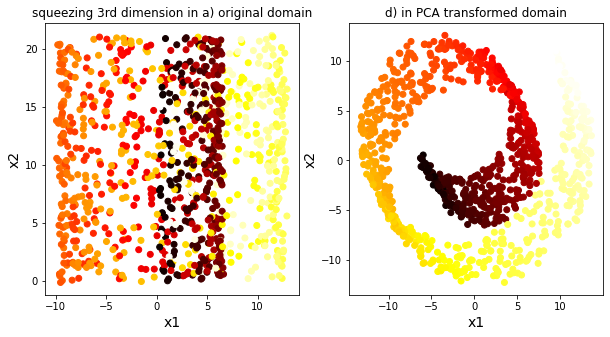

In [76]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X[:,0],X[:,1],c=t, cmap=plt.cm.hot);
plt.title("squeezing 3rd dimension in a) original domain")
plt.xlabel('x1',fontsize='14')
plt.ylabel('x2',fontsize='14')
plt.subplot(122)
plt.scatter(X2D[:,0],X2D[:,1],c=t, cmap=plt.cm.hot)
plt.xlabel('x1',fontsize='14')
plt.ylabel('x2',fontsize='14')
plt.title("d) in PCA transformed domain");

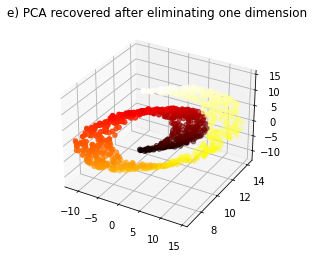

In [77]:
X2DR = pca.inverse_transform(X2D)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X2DR[:,0],X2DR[:,1],X2DR[:,2],c=t, cmap=plt.cm.hot);
plt.title('e) PCA recovered after eliminating one dimension')
plt.show()

This part so far is the same as we did in the first example (except we only used sklearn instead of SVD matrices).
Now let us use some more advance PCA forms using the sklearn class "KernelPCA" that has many variants.
First we will use the KernelPCA but with the linear version (so it will be similar to PCA)

tranformed domain has only as many dimensions as components (1000, 2)


Text(0.5, 1.0, 'f) Linear PCA (transformed domain)')

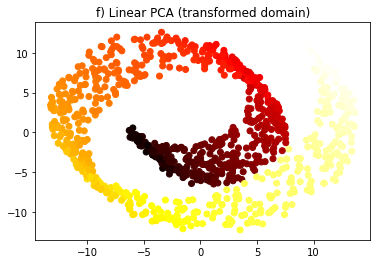

In [84]:
from sklearn.decomposition import KernelPCA
# need to use fit_inverse_transform=True to be able to map back and forth.
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
X2Db = lin_pca.fit_transform(X)
print("tranformed domain has only as many dimensions as components", X2Db.shape)
fig = plt.figure()
plt.scatter(X2Db[:,0],X2Db[:,1],c=t, cmap=plt.cm.hot)
plt.title("f) Linear PCA (transformed domain)")

In [85]:
X2Db.shape

(1000, 2)

Text(0.5, 0.92, 'g) Linear PCA (recovered domain)')

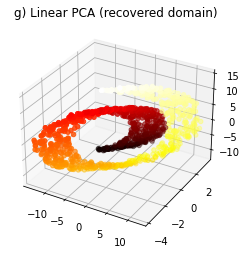

In [86]:
X2DbI = lin_pca.inverse_transform(X2Db)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X2DbI[:,0],X2DbI[:,1],X2DbI[:,2],c=t, cmap=plt.cm.hot)
plt.title("g) Linear PCA (recovered domain)")

Now we will use the Radial Basis Functions "RBF" kernel. The transformation is done through the "kernel trick".

after transform we have (1000, 2)


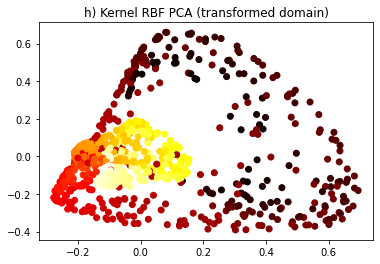

In [87]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04,fit_inverse_transform=True)
X2Dc = rbf_pca.fit_transform(X)
print('after transform we have',X2Dc.shape)
fig = plt.figure()
plt.scatter(X2Dc[:,0],X2Dc[:,1],c=t, cmap=plt.cm.hot)
plt.title("h) Kernel RBF PCA (transformed domain)");

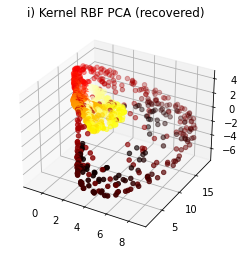

In [88]:
X2DcI = rbf_pca.inverse_transform(X2Dc)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X2DcI[:,0],X2DcI[:,1],X2DcI[:,2],c=t, cmap=plt.cm.hot)
plt.title("i) Kernel RBF PCA (recovered)");

Although the recovered space is 3D, we can project the recovered spaces to 2D to see the non-linear effect.

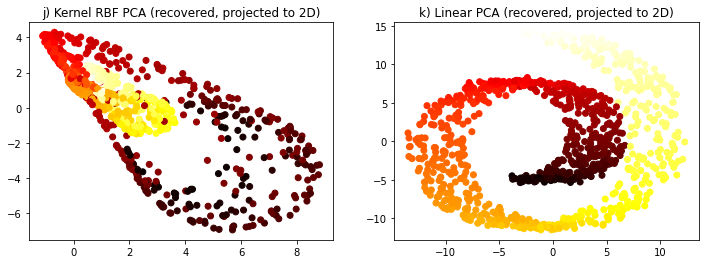

In [89]:
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(X2DcI[:,0],X2DcI[:,2],c=t, cmap=plt.cm.hot)
plt.title("j) Kernel RBF PCA (recovered, projected to 2D)")
plt.subplot(122)
plt.scatter(X2DbI[:,0],X2DbI[:,2],c=t, cmap=plt.cm.hot)
plt.title("k) Linear PCA (recovered, projected to 2D)");

In [90]:
from sklearn.metrics import mean_squared_error
print('linear',mean_squared_error(X,X2DbI))
print('rbf',mean_squared_error(X,X2DcI))

linear 51.5846349023089
rbf 31.833632434626338


# MDS, Isomap and t-SNE
Calculate MDS, Isomap and t-SNE for MNIST.
For more examples and documentation see [here](https://scikit-learn.org/stable/modules/manifold.html#)

In [91]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [92]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [93]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, learning_rate='auto',init='random')
X_reduced_tsne = tsne.fit_transform(X)

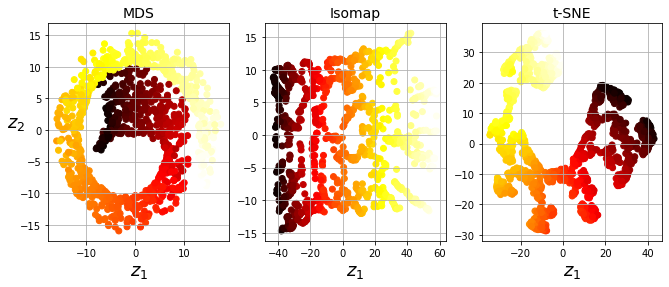

In [94]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Now let us apply the LLE method instead of PCA.

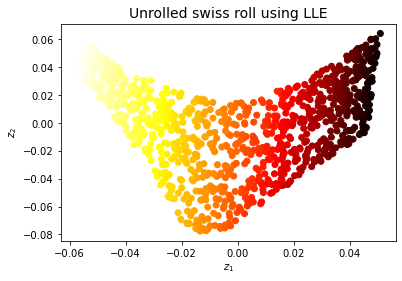

In [95]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$");

## Exercise 3: Compression by TSVD
Apply compression to the MNIST dataset and compare with original data.\
Use the parameter "explained_variance_ratio" to define the amount of compression.\
This parameter tells us how much of the original variance is contained on each dimension (all dimensions sum to one).\
To define the optimal number of dimensions we can sum the percentage of variances along all dimensions before the cutoff.\
Try different percentages and see how much information you loss in each case.

In [97]:
useSL=False
if useSL:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.uint8)
    print(type(mnist))
    mnist.keys()
    X = mnist["data"]   
    y = mnist["target"]
else: #use TF 
    from tensorflow import keras
    import tensorflow as tf
    mnist = keras.datasets.mnist
    (X,y),(Xt,yt) = mnist.load_data()
    print(X.shape)
    X=X[:60000].reshape(60000,28*28) # to make it compatible with SL version
    y=y[:60000]

(60000, 28, 28)


In [98]:
from sklearn.model_selection import train_test_split
try:
    X = X.to_numpy(copy=True)
except:
    print("already Numpy array")    
X_train, X_test, y_train, y_test = train_test_split(X, y)

already Numpy array


In [99]:
X.shape

(60000, 784)

In [100]:
# example for the numpy function cumsum
aa=np.arange(1,10)
np.cumsum(aa)

array([ 1,  3,  6, 10, 15, 21, 28, 36, 45])

In [101]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print('number of necessary components', d)
print('which is only %1.2f percent'%(d/X_train.shape[1]*100))
print('in dimensions but 95% in variance')

number of necessary components 154
which is only 19.64 percent
in dimensions but 95% in variance


Because most variance is explained in the first dimensions, we get small lost in information but large compression.

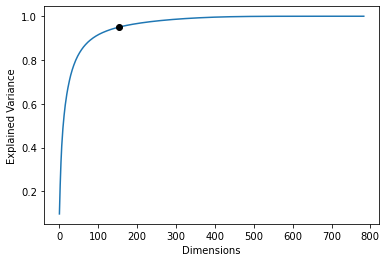

In [102]:
plt.plot(cumsum)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot(d, 0.95, "ko")

Now that we know the optimal number of dimensions, we can recover the numbers to the original space\
with PCA as before (fit_transform + inverse_transform). This space is again 28x28 dimensions.

In [103]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [104]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

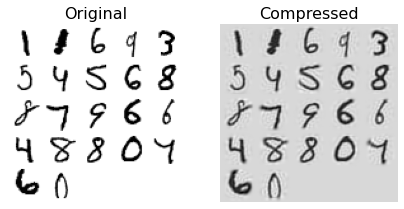

In [105]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

Actually we can do this directly in one pass by passing to PCA parameter "n_components" a number less than 1 (explained variance)

Text(0.5, 1.0, 'Compressed')

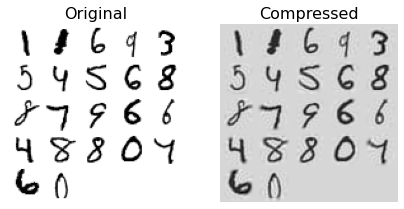

In [106]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

## Exercise 4: Kernel PCA
Apply PCA (linear) and Kernel PCA (non linear) to the half moon and circle datasets without using kernelPCA from sklearn!\
That is, write a kernelPCA from scratch.


This is an example from the following book:\
Python Machine Learning 3rd Edition by Sebastian Raschka, Packt Publishing Ltd. 2019
Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition
Code License: MIT License

### Review of Eigenvalues and Eigenvectors
Notice that here, instead of using SVD we use the eigenvector - eigenvalue decomposition to get V.\
This is a more fundamental transformation that lies at the heart of physics, in particular Quantum Physics (Heisembergh's approach). \
$v_i$ is an eigenvector of $A$ if \
$ A v_i = \lambda_i v_i $ \
with $\lambda_i$ being an eigenvalue. \
Making $A = X^T X$ \
or $A = X X^T $ \
and representing $X$ with the SVD, we see that the eigenvectors of $X^T X$ are $V$ and the eigenvectors of $X X^T$ are $U$ \
For example, $ X^T X = V \Sigma U^T U \Sigma V^T = V \Sigma^2 V^T $ \
Then $A V = V \Sigma^2 = \Sigma^2 V$ \
Then $V$ are the eigenvectors and $\Sigma^2$ are the eigenvalues \
Therefore we can use calculate the projection matrix $V$ from the eigenvector decomposition of the covariance of $X$ which is $X^T X$

In [107]:
## From book
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np


from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import exp
else:
    from scipy import exp

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

/tmp/ipykernel_35436/3983614729.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if scipy_version >= Version('1.4.1'):


#### Moons data
Let us try with a moons dataset. 

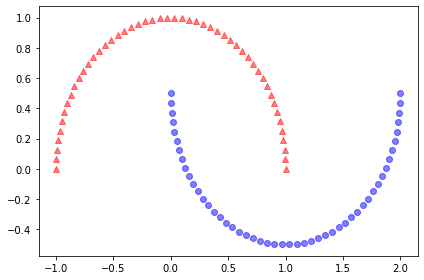

In [108]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

Linear PCA rotates and shift the data somewhat but not enough to separate them.\
The figure on the right illustrates how selecting one of the components does not separate properly.\
There is an artificial vertical shift on the right to illustrate the area where there is overlapping.


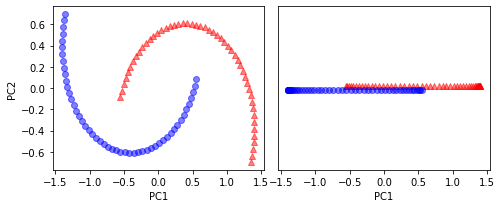

In [109]:
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

Now, we the kernel PCA we see a much stronger separation (rotation and shifting)

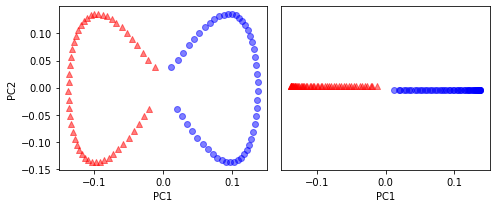

In [110]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

### Circles dataset
The same tests with a different data set.\
The make_circles functions illustrates better the power of Kernel PCA.

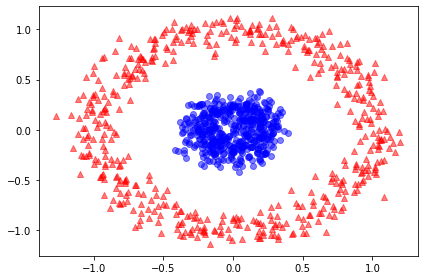

In [111]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_15.png', dpi=300)
plt.show()

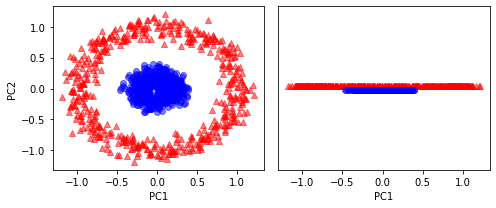

In [112]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_16.png', dpi=300)
plt.show()

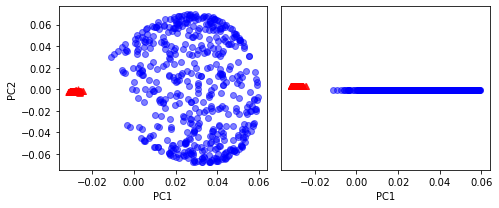

In [117]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_17.png', dpi=300)
plt.show()

Let us do KernelPCA with scikitlearn. The results are the same, but we don't need the function defined above.

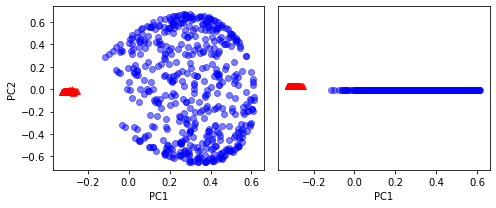

In [118]:
from sklearn.decomposition import KernelPCA
skl_kernelpca=KernelPCA(n_components=2,kernel='rbf',gamma=15)
X_kpcab=skl_kernelpca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpcab[y == 0, 0], X_kpcab[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpcab[y == 1, 0], X_kpcab[y == 1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpcab[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpcab[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_17.png', dpi=300)
plt.show()